# New York City Taxi Fare Prediction

Assume working as business analysts in a start-up, named Pickup. The company plans to access taxi markets in New York City but fierce competition makes our boss want business analysts to analyze other rivals' pricing strategies and build a model to make price predictions before entering the markets. The boss wants to provide a lower price to attract customers from rival companies but does not want to lose too much. Hence, the accuracy of the model is the priority. If there is any discovery, include it in the report as well.

# Import libraries

In [1]:
!pip install opendatasets --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import opendatasets as od
import pandas as pd
import random
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

%autosave 60

Autosaving every 60 seconds


## Load data from Kaggle

In [3]:
dataset_url = 'https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: evalyr
Your Kaggle Key: ··········


100%|██████████| 1.56G/1.56G [00:13<00:00, 122MB/s]



Extracting archive ./new-york-city-taxi-fare-prediction/new-york-city-taxi-fare-prediction.zip to ./new-york-city-taxi-fare-prediction


In [4]:
# The dataset will be save in a folder called 'new-york-city-taxi-fare-prediction'. Save that folder as 'data_dir'.
data_dir = 'new-york-city-taxi-fare-prediction'

In [5]:
# Check the content of the folder and size of each file.
!dir -l {data_dir}

total 5564956
-rw-r--r-- 1 root root        486 Feb 10 00:19 GCP-Coupons-Instructions.rtf
-rw-r--r-- 1 root root     343271 Feb 10 00:19 sample_submission.csv
-rw-r--r-- 1 root root     983020 Feb 10 00:19 test.csv
-rw-r--r-- 1 root root 5697178298 Feb 10 00:20 train.csv


In [6]:
!head {data_dir}/train.csv

key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.84161,40.712278,1
2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.76127,-73.991242,40.750562,2
2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.98713,40.733143,-73.991567,40.758092,1
2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.73163,-73.972892,40.758233,1
2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.9513,40.774138,-73.990095,40.751048,1
2012-12-03 13:10:00.000000125,9,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.99

In [7]:
# Number of records in train data
!wc -l {data_dir}/train.csv

55423856 new-york-city-taxi-fare-prediction/train.csv


In [8]:
# Number of records in test data
!wc -l {data_dir}/test.csv

9914 new-york-city-taxi-fare-prediction/test.csv


In [9]:
# Number of records in submission data
!wc -l {data_dir}/sample_submission.csv

9915 new-york-city-taxi-fare-prediction/sample_submission.csv


Since this dataset is enormous, I'll extract 1% of the dataset to build models.

In [10]:
# Decide what % of size we want to use. Change this.
sample_frac = 0.01

In [11]:
%%time
selected_cols = 'fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count'.split(',')
dtypes = {
    'fare_amount': 'float32',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'passenger_count': 'float32'
}

def skip_row(row_idx):
    if row_idx == 0:
        return False
    return random.random() > sample_frac

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 16.9 µs


# Dataset, random=42

In [12]:
random.seed(42)
df_train = pd.read_csv(data_dir + '/train.csv', 
                 usecols = selected_cols, 
                 dtype = dtypes, 
                 parse_dates = ['pickup_datetime'], 
                 skiprows = skip_row)

In [13]:
df_train.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.0,2014-12-06 20:36:22+00:00,-73.979813,40.751904,-73.979446,40.755481,1.0
1,8.0,2013-01-17 17:22:00+00:00,0.000000,0.000000,0.000000,0.000000,2.0
2,8.9,2011-06-15 18:07:00+00:00,-73.996330,40.753223,-73.978897,40.766963,3.0
3,6.9,2009-12-14 12:33:00+00:00,-73.982430,40.745747,-73.982430,40.745747,1.0
4,7.0,2013-11-06 11:26:54+00:00,-73.959061,40.781059,-73.962059,40.768604,1.0


In [14]:
df_train.shape

(552450, 7)

There are 554,450 records in 1% of the dataset.

In [15]:
df_test = pd.read_csv(data_dir + '/test.csv', dtype = dtypes, parse_dates = ['pickup_datetime'])
df_test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1.0
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1.0
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746139,1.0
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751635,1.0
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1.0


In [16]:
df_sub = pd.read_csv(data_dir + '/sample_submission.csv')
df_sub.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35


# Data processing

In [17]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000
mean,11.354059,-72.497063,39.910500,-72.504326,39.934257,1.684983
std,9.811924,11.618246,8.061114,12.074346,9.255058,1.337664
min,-52.000000,-1183.362793,-3084.490234,-3356.729736,-2073.150613,0.000000
25%,6.000000,-73.992020,40.734875,-73.991425,40.733988,1.000000
50%,8.500000,-73.981819,40.752621,-73.980179,40.753102,1.000000
75%,12.500000,-73.967155,40.767036,-73.963737,40.768060,2.000000
max,499.000000,2420.209473,404.983337,2467.752686,3351.403027,208.000000


Before training the dataset, I check if is there weird numeric values in it. From the above table, I notice numbers in min and max rows, they are unreasonable.

In [18]:
# Check if there's null value.
df_train.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [19]:
df_test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974716,40.751041,-73.973656,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252190,40.573143,-74.263245,40.568973,1.000000
25%,-73.992500,40.736125,-73.991249,40.735254,1.000000
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000
max,-72.986534,41.709557,-72.990967,41.696683,6.000000


In [20]:
df_train['pickup_datetime'].min(), df_train['pickup_datetime'].max()

(Timestamp('2009-01-01 00:11:46+0000', tz='UTC'),
 Timestamp('2015-06-30 23:59:54+0000', tz='UTC'))

In [21]:
df_test['pickup_datetime'].min(), df_test['pickup_datetime'].max()

(Timestamp('2009-01-01 11:04:24+0000', tz='UTC'),
 Timestamp('2015-06-30 20:03:50+0000', tz='UTC'))

The duration of train and test datasets are the same.

## Exclude Outliers

I'll use the following ranges:

- `fare_amount`: \$1 to \$500
- `longitudes`: -75 to -72
- `latitudes`: 40 to 42
- `passenger_count`: 1 to 6

In [22]:
def remove_outliers(df):
    return df[(df['fare_amount'] >= 1.) & 
              (df['fare_amount'] <= 500.) &
              (df['pickup_longitude'] >= -75) & 
              (df['pickup_longitude'] <= -72) & 
              (df['dropoff_longitude'] >= -75) & 
              (df['dropoff_longitude'] <= -72) & 
              (df['pickup_latitude'] >= 40) & 
              (df['pickup_latitude'] <= 42) & 
              (df['dropoff_latitude'] >=40) & 
              (df['dropoff_latitude'] <= 42) & 
              (df['passenger_count'] >= 1) & 
              (df['passenger_count'] <= 6)]

In [23]:
df_train = remove_outliers(df_train)

In [24]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,538840.000000,538840.000000,538840.000000,538840.000000,538840.000000,538840.000000
mean,11.343509,-73.975121,40.750992,-73.974350,40.751343,1.690828
std,9.727098,0.039398,0.030071,0.038601,0.033206,1.306905
min,1.000000,-74.934593,40.063896,-74.946442,40.054207,1.000000
25%,6.000000,-73.992241,40.736542,-73.991608,40.735527,1.000000
50%,8.500000,-73.982101,40.753338,-73.980621,40.753797,1.000000
75%,12.500000,-73.968376,40.767464,-73.965416,40.768372,2.000000
max,499.000000,-72.471581,41.787712,-72.113823,41.806300,6.000000


Now the dataset looks better.

Separate the 'pickup_datetime' Column:
  * `Year`
  * `Month`
  * `Day`
  * `Weekday`
  * `Hour`

In [25]:
def dateparts(df, col):
    df[col + '_year'] = df[col].dt.year
    df[col + '_month'] = df[col].dt.month
    df[col + '_day'] = df[col].dt.day
    df[col + '_weekday'] = df[col].dt.weekday
    df[col + '_hour'] = df[col].dt.hour

In [26]:
dateparts(df_train, 'pickup_datetime')
df_train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour
0,4.0,2014-12-06 20:36:22+00:00,-73.979813,40.751904,-73.979446,40.755481,1.0,2014,12,6,5,20
2,8.9,2011-06-15 18:07:00+00:00,-73.996330,40.753223,-73.978897,40.766963,3.0,2011,6,15,2,18
3,6.9,2009-12-14 12:33:00+00:00,-73.982430,40.745747,-73.982430,40.745747,1.0,2009,12,14,0,12
4,7.0,2013-11-06 11:26:54+00:00,-73.959061,40.781059,-73.962059,40.768604,1.0,2013,11,6,2,11
5,15.5,2014-12-08 01:00:16+00:00,-73.957672,40.717888,-73.942581,40.686397,1.0,2014,12,8,0,1


In [27]:
dateparts(df_test, 'pickup_datetime')
df_test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1.0,2015,1,27,1,13
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1.0,2015,1,27,1,13
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746139,1.0,2011,10,8,5,11
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751635,1.0,2012,12,1,5,21
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1.0,2012,12,1,5,21


## Distance Between Pickup and Drop (Using longitude & latitude)

In [28]:
def haversine_np(lon1, lat1, lon2, lat2):
    # Calculate the great circle distance between two points on the earth (specified in decimal degrees)
    # All args must be of equal length.    

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [29]:
def trip_distance(df):
    df['trip_distance'] = haversine_np(df['pickup_longitude'], df['pickup_latitude'], df['dropoff_longitude'], df['dropoff_latitude'])

In [30]:
%%time
trip_distance(df_train)
df_train.head()

CPU times: user 39 ms, sys: 9.14 ms, total: 48.1 ms
Wall time: 52.7 ms


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance
0,4.0,2014-12-06 20:36:22+00:00,-73.979813,40.751904,-73.979446,40.755481,1.0,2014,12,6,5,20,0.398747
2,8.9,2011-06-15 18:07:00+00:00,-73.996330,40.753223,-73.978897,40.766963,3.0,2011,6,15,2,18,2.117609
3,6.9,2009-12-14 12:33:00+00:00,-73.982430,40.745747,-73.982430,40.745747,1.0,2009,12,14,0,12,0.000088
4,7.0,2013-11-06 11:26:54+00:00,-73.959061,40.781059,-73.962059,40.768604,1.0,2013,11,6,2,11,1.406799
5,15.5,2014-12-08 01:00:16+00:00,-73.957672,40.717888,-73.942581,40.686397,1.0,2014,12,8,0,1,3.722912


In [31]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance
count,538840.000000,538840.000000,538840.000000,538840.000000,538840.000000,538840.000000,538840.000000,538840.000000,538840.000000,538840.000000,538840.000000,5.388400e+05
mean,11.343509,-73.975121,40.750992,-73.974350,40.751343,1.690828,2011.738091,6.267556,15.728092,3.037171,13.508218,3.329444e+00
std,9.727098,0.039398,0.030071,0.038601,0.033206,1.306905,1.863060,3.435919,8.693001,1.950373,6.514391,3.745527e+00
min,1.000000,-74.934593,40.063896,-74.946442,40.054207,1.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,1.816827e-07
25%,6.000000,-73.992241,40.736542,-73.991608,40.735527,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000,1.254190e+00
50%,8.500000,-73.982101,40.753338,-73.980621,40.753797,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000,2.154720e+00
75%,12.500000,-73.968376,40.767464,-73.965416,40.768372,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000,3.913853e+00
max,499.000000,-72.471581,41.787712,-72.113823,41.806300,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,1.134746e+02


In [32]:
# Frequency of month
fre_month = pd.crosstab(index=df_train['pickup_datetime_month'], columns = 'count')
fre_month_tab = fre_month / fre_month.sum()
fre_month_tab.sort_values('count', ascending = False)

col_0,count
pickup_datetime_month,
5,0.093957
3,0.093195
4,0.091972
6,0.089930
1,0.089290
2,0.084506
10,0.080553
12,0.076461
9,0.076290


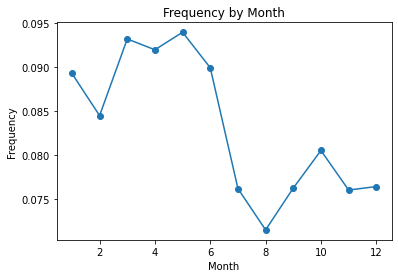

In [33]:
plt.plot(fre_month_tab, marker = 'o')
plt.title('Frequency by Month')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

From January to June in a year, more customers choose to take a taxi.

In [34]:
# Frequency of weekday
fre_weekday = pd.crosstab(index=df_train['pickup_datetime_weekday'], columns = 'count')
fre_weekday_tab = fre_weekday / fre_weekday.sum()
fre_weekday_tab.sort_values('count', ascending = False)

col_0,count
pickup_datetime_weekday,
4,0.154448
5,0.151069
3,0.149380
2,0.145043
1,0.139795
6,0.131002
0,0.129263


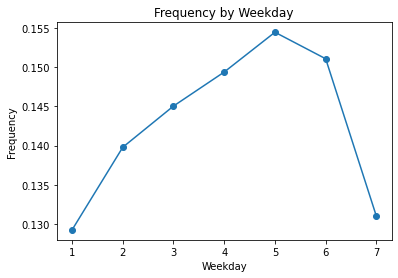

In [35]:
x = range(7)
plt.plot(fre_weekday_tab, marker = 'o')
plt.title('Frequency by Weekday')
plt.xticks(ticks = x, labels = [str(i + 1) for i in x])
plt.xlabel('Weekday')
plt.ylabel('Frequency')
plt.show()

We can see that the peak is located on Friday.

In [36]:
# Frequency of hour
fre_hour = pd.crosstab(index=df_train['pickup_datetime_hour'], columns = 'count')
fre_hour_tab = fre_hour / fre_hour.sum()
fre_hour_tab.sort_values('count', ascending = False)

col_0,count
pickup_datetime_hour,
19,0.062675
18,0.059938
20,0.058858
21,0.057329
22,0.055556
14,0.050872
17,0.049748
23,0.049345
13,0.048842


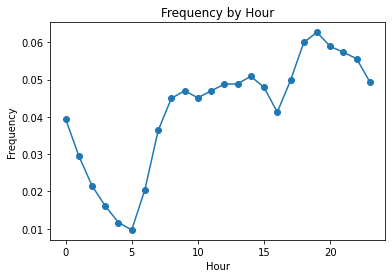

In [37]:
plt.plot(fre_hour_tab, marker='o')
plt.title('Frequency by Hour')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.show()

Hours from 7 to 00 (expect normal sleeping time), more people take a taxi as time goes by, and reach a peak at 7 pm, then the value goes down gradually. 

In [38]:
%%time
trip_distance(df_test)
df_test.head()

CPU times: user 5.92 ms, sys: 0 ns, total: 5.92 ms
Wall time: 5.93 ms


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1.0,2015,1,27,1,13,2.321720
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1.0,2015,1,27,1,13,2.423889
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746139,1.0,2011,10,8,5,11,0.618009
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751635,1.0,2012,12,1,5,21,1.959910
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1.0,2012,12,1,5,21,5.383931


In [39]:
df_test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974716,40.751041,-73.973656,40.751743,1.671273,2011.815816,6.857979,16.194170,2.852834,13.467420,3.433217
std,0.042774,0.033541,0.039072,0.035435,1.278747,1.803347,3.353272,8.838482,1.994451,6.868584,3.969883
min,-74.252190,40.573143,-74.263245,40.568973,1.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000009
25%,-73.992500,40.736125,-73.991249,40.735254,1.000000,2010.000000,4.000000,9.000000,1.000000,8.000000,1.297281
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000,2012.000000,7.000000,16.000000,3.000000,15.000000,2.215669
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000,2014.000000,10.000000,25.000000,5.000000,19.000000,4.042928
max,-72.986534,41.709557,-72.990967,41.696683,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,99.933359


# Split dataset

In [40]:
# Set random_state=42 so we always have the same test and val data.
train_df, val_df = train_test_split(df_train, test_size = 0.2, random_state = 42)

In [41]:
# train : val = 0.8 : 0.2
train_df.shape, val_df.shape

((431072, 13), (107768, 13))

**Train Dataset**

In [42]:
train_inputs = train_df.drop(columns = ['fare_amount', 'pickup_datetime'])
train_inputs

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance
97996,-73.981339,40.747112,-73.986038,40.761682,1.0,2012,6,15,4,22,1.666688
24939,-73.993408,40.721783,-73.951218,40.774362,1.0,2014,3,5,2,22,6.837776
103945,-74.001640,40.735973,-73.982849,40.776028,2.0,2011,2,19,5,22,4.723865
468460,-73.960411,40.778698,-73.953850,40.778727,1.0,2012,7,14,5,16,0.552342
332404,-73.998703,40.734863,-73.974426,40.761554,1.0,2009,12,24,3,14,3.601960
...,...,...,...,...,...,...,...,...,...,...,...
113003,-73.982864,40.762505,-73.993523,40.752334,2.0,2011,3,29,1,2,1.443180
265659,-73.959106,40.809608,-73.978371,40.766917,1.0,2009,4,29,2,0,5.013432
375012,-73.982201,40.776855,-73.991417,40.749823,2.0,2009,6,9,1,22,3.102494
135184,-74.001434,40.730949,-73.956467,40.775007,2.0,2010,8,2,0,21,6.188473


In [43]:
train_outputs = train_df['fare_amount']
train_outputs

97996      7.3
24939     15.0
103945    12.5
468460     4.1
332404    10.9
          ... 
113003     4.9
265659    11.7
375012     9.3
135184    13.7
124971     5.3
Name: fare_amount, Length: 431072, dtype: float32

**Val Dataset**

In [44]:
val_inputs = val_df.drop(columns = ['fare_amount', 'pickup_datetime'])
val_inputs

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance
138985,-73.988091,40.758911,-73.982788,40.782118,1.0,2009,2,25,2,20,2.617227
115859,-73.954468,40.789360,-73.945244,40.802702,2.0,2014,4,24,3,17,1.673524
352143,-74.003998,40.707363,-73.960571,40.812355,3.0,2009,10,4,6,1,12.226335
339828,-73.967766,40.802422,-73.950272,40.802175,6.0,2013,3,2,5,13,1.471657
98587,-73.991814,40.750168,-73.984535,40.752948,1.0,2011,4,12,1,13,0.686345
...,...,...,...,...,...,...,...,...,...,...,...
461175,-74.004211,40.738056,-74.001198,40.731024,1.0,2010,6,8,1,22,0.821501
196275,-73.989449,40.741711,-74.006966,40.706005,5.0,2015,4,7,1,21,4.233118
14776,-73.959274,40.772045,-73.949448,40.781805,2.0,2013,9,21,5,0,1.363884
63318,-73.983528,40.746555,-73.979774,40.743295,1.0,2010,1,22,4,23,0.480950


In [45]:
val_outputs = val_df['fare_amount']
val_outputs

138985     7.3
115859     6.5
352143    24.9
339828     7.0
98587      5.7
          ... 
461175     5.7
196275    11.5
14776      5.0
63318      3.7
118806    18.5
Name: fare_amount, Length: 107768, dtype: float32

**Test Dataset**

In [46]:
test_inputs = df_test.drop(columns = ['key', 'pickup_datetime'])
test_inputs

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance
0,-73.973320,40.763805,-73.981430,40.743835,1.0,2015,1,27,1,13,2.321720
1,-73.986862,40.719383,-73.998886,40.739201,1.0,2015,1,27,1,13,2.423889
2,-73.982521,40.751259,-73.979652,40.746139,1.0,2011,10,8,5,11,0.618009
3,-73.981163,40.767807,-73.990448,40.751635,1.0,2012,12,1,5,21,1.959910
4,-73.966049,40.789776,-73.988564,40.744427,1.0,2012,12,1,5,21,5.383931
...,...,...,...,...,...,...,...,...,...,...,...
9909,-73.968124,40.796997,-73.955643,40.780388,6.0,2015,5,10,6,12,2.123367
9910,-73.945511,40.803600,-73.960213,40.776371,6.0,2015,1,12,0,17,3.268916
9911,-73.991600,40.726608,-73.789742,40.647011,6.0,2015,4,19,6,20,19.171439
9912,-73.985573,40.735432,-73.939178,40.801731,6.0,2015,1,31,5,1,8.338278


# Linear Regression

In [47]:
linear_model = LinearRegression()
linear_model.fit(train_inputs, train_outputs)
print('Intercept:', linear_model.intercept_)
print('Coefficiets:', linear_model.coef_)

Intercept: 1297.5324733471643
Coefficiets: [ 1.09257579e+01 -1.63849642e+01  5.94709100e+00 -1.07978275e+01
  2.64282177e-02  5.28095944e-01  7.54565179e-02  7.06804211e-04
 -4.97905132e-02  1.07334126e-02  2.04182184e+00]


First, go with the Linear Regression Model as the basic prediction. From the coefficients, we can see the third one (5.947), which is dropoff longitude, hugely influenced our prediction.

In [48]:
train_pred = linear_model.predict(train_inputs)
train_rmse = mean_squared_error(train_outputs, train_pred, squared = False)
train_rmse

5.334849129797099

In [49]:
val_pred = linear_model.predict(val_inputs)
val_rmse = mean_squared_error(val_outputs, val_pred, squared = False)
val_rmse

5.273300688772226

# Random Forest

In [50]:
randomforest_model = RandomForestRegressor(n_estimators = 100, max_depth=10, random_state = 42)
randomforest_model.fit(train_inputs, train_outputs)

RandomForestRegressor(max_depth=10, random_state=42)

                         Importance
trip_distance             88.189881
dropoff_longitude          4.343364
pickup_datetime_year       2.450162
pickup_longitude           1.810637
dropoff_latitude           1.529928
pickup_latitude            0.691521
pickup_datetime_hour       0.394342
pickup_datetime_month      0.221378
pickup_datetime_day        0.198620
pickup_datetime_weekday    0.116340
passenger_count            0.053828


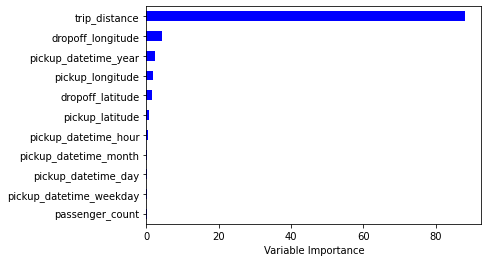

In [51]:
Importance_ = pd.DataFrame({'Importance':randomforest_model.feature_importances_ * 100}, index=train_inputs.columns)
Importance = Importance_.sort_values('Importance', axis = 0, ascending = False)[0:20]
Importance.plot(kind='barh', color='b', ).invert_yaxis()
print(Importance)
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

The bar chart shows the importance of each feature, we can understand that in
the Random Forest Model, trip_distance dramatically affected our prediction.

In [52]:
train_pred = randomforest_model.predict(train_inputs)
train_rmse = mean_squared_error(train_outputs, train_pred, squared = False)
train_rmse

3.694146822623311

In [53]:
val_pred = randomforest_model.predict(val_inputs)
val_rmse = mean_squared_error(val_outputs, val_pred, squared = False)
val_rmse

3.9666406098535503

# Gradient Boosting

In [54]:
boost_model = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.01, random_state = 42)
boost_model.fit(train_inputs, train_outputs)

GradientBoostingRegressor(learning_rate=0.01, random_state=42)

trip_distance              96.639904
dropoff_longitude           1.777558
pickup_datetime_year        1.185595
pickup_longitude            0.314724
dropoff_latitude            0.082219
pickup_latitude             0.000000
passenger_count             0.000000
pickup_datetime_month       0.000000
pickup_datetime_day         0.000000
pickup_datetime_weekday     0.000000
pickup_datetime_hour        0.000000
dtype: float64


Text(0.5, 0, 'Variable Importance')

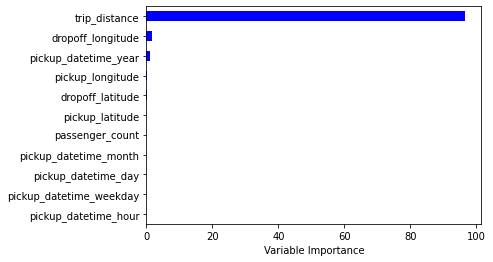

In [55]:
feature_importance = boost_model.feature_importances_ * 100
rel_imp = pd.Series(feature_importance, index=train_inputs.columns).sort_values(ascending = False, inplace = False)
rel_imp = rel_imp[0:20]
print(rel_imp)
rel_imp.plot(kind = 'barh', color = 'b', ).invert_yaxis()
plt.xlabel('Variable Importance')

We can learn from the above graph that in the Gradient Boosting Model, the
importance is presented more extremely. There are only 5 features that have an
influence on our prediction. Among all, trip_distance took up to 97 percent.

In [56]:
train_pred = boost_model.predict(train_inputs)
train_rmse = mean_squared_error(train_outputs, train_pred, squared = False)
train_rmse

5.760594627002767

In [57]:
val_pred = boost_model.predict(val_inputs)
val_rmse = mean_squared_error(val_outputs, val_pred, squared = False)
val_rmse

5.69832556881213

I checked the RMSEs of Train and Val datasets, they showed 5.76 and 5.69, which
surprisingly were worse than the ones of the Linear Regression Model.

## Conlusion

Among these 3 models, the Random Forest Model performs the best by comparing all RMSE values.

According to our aforementioned, first, I will suggest our boss place advertisements on specific periods based on the line charts of frequency to make our brand can be exposed to more customers and also make his investment more effective. Second, it would be better if I could use the whole dataset to build models. However, due to the limitation of the computer, I would suggest the boss use Random Forest Model to predict taxi fares because this model manifests the best and has the least RMSE value. If it is not urgent, I would suggest generating more random forest models and then averaging all predictions to get better performance.